<a href="https://colab.research.google.com/github/Albmargar1/ClickbaitDetector/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name = 'Index'> </a> <font color='orange'> Índice </font>

* [Notas iniciales](#NotasIniciales)
* Instalación del entorno
* [Pipeline](#Pipeline)
* Análisis descriptivo de los datos
* Pruebas, con input:
  * 'postText' (Texto del tweet)
    * Búsqueda de hiperparámetros en BERT
    * Búsqueda de hiperparámetros en RoBERTa
    * Búsqueda de hiperparámetros en XLN
  * 'postText' (Texto del tweet) + 'targetKeywords'
    * Búsqueda de hiperparámetros en BERT
    * Búsqueda de hiperparámetros en RoBERTa
    * Búsqueda de hiperparámetros en XLN
  * 'postText' (Texto del tweet) + 'targetParagraphs'
    * Búsqueda de hiperparámetros en Longformer
* Evaluación del dataset para cada input y checkpoint correspondiente. 
  * Comparación con estado del arte
* Análisis de errores

# <a name="NotasIniciales"> </a> <font color='orange'> Notas iniciales </font>

* Cambiar métricas, aparecen uans de GLUE

<font color='lightgreen'> Comentarios </font>
* # NO EJECUTAR TODAS LAS CELDAS A LA VEZ
* Este es el **archivo principal** donde se recogen todas las pruebas. **Cada prueba** posee una **configuración de parámetros difentes**, y llaman a una **única función** que recoge el pipeline global, controlando mediante flags qué funciones deben ejecutarse. Dichas funciones se encuentran todas en la carpeta 'utils'
* El índice contiene enlaces a cada sección para una navegación más cómoda. 

<font color='lightgreen'> Referencias </font>

* [BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding](https://arxiv.org/pdf/1810.04805.pdf)

Quiero mencionar dos proyectos que hacen un trabajo muy parecido. Aunque obtengo ideas de ellos, considero que no hay plagio. Dichos trabajos servirán como referencia para comparar el modelo aquí desarrollado.
* [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT)
* [BERT, XLNet or RoBERTa: The Best Transfer Learning Model to Detect
Clickbaits](https://www.researchgate.net/publication/356276903_BERT_XLNet_or_RoBERTa_The_Best_Transfer_Learning_Model_to_Detect_Clickbaits)


# <font color='orange'> Parámetros </font>
Por comodidad, los parámetros a ajustar se encuentran en la parte superior del cuaderno.

In [15]:
default_config = {}

# Directories
default_config['train_dir'] = '/content/ClickbaitDetector/data/webis_train.csv'
default_config['test_dir'] = '/content/ClickbaitDetector/data/webis_test.csv'

# Flags
default_config['do_descriptive_analysis'] = False
default_config['do_training'] = False
default_config['do_evaluation_test'] = False

# Descriptive analysis
default_config['logger_transformers'] = 'error'

# Dataset
default_config['train_val_split'] = 0.15
default_config['clip'] = [0.5,0.5]
default_config['inputs'] = ['postText']

# Training
default_config['learning_rate'] = 1e-5
default_config['batch_size'] = 8
default_config['num_epochs'] = 2
default_config['weight_decay'] = 1e-5

# Hyperparameter search
default_config['n_trials'] = 1

default_config['hp'] = {'learning_rate': [2e-5, 5e-5], # Uniform sampling between min-max
                        'epochs': [1,2], # Pick int between min-max
                        'batch_size_train': [16, 32]} # Pick one

# Checkpoint
default_config['checkpoint'] = 'bert-base-uncased'
default_config['model_name'] = default_config['checkpoint'] + '-clickbait'
default_config['finetuned_model_dir'] = './ClickbaitDetector/model/' + default_config['model_name'] 
default_config['cloud_dir'] = 'Stremie/'+default_config['model_name'] + '-best'

[Volver al índice](#Index)

# <font color='orange'> Setup </font>
Clonar el proyecto, instalar e importar dependencias. Puede durar varios minutos.

In [4]:
!git clone https://github.com/Albmargar1/ClickbaitDetector -q

fatal: destination path 'ClickbaitDetector' already exists and is not an empty directory.


In [5]:
!pip install -q transformers

In [6]:
!pip install datasets -q folium==0.2.1 # Tengo que especificar la versión de folium o da error al instalar la librería de datasets de Hugging Face

In [7]:
!pip install optuna -q

In [8]:
import sys
sys.path.append('/content/ClickbaitDetector/')

import optuna
from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification
import datasets
from datasets import load_metric
import torch
from torch.utils.data import DataLoader, SequentialSampler

from utils import data_processing, descriptive_analysis
from utils.Objective import Objective

[Volver al índice](#Index)
<a name='Pipeline'> </a>
# <font color='orange'> Pipeline </font>

 

Tweets legítimos: 14777 
Tweets clickbait: 4761 
Tweets mal etiquetados: 0 
Proporción tweets clickbait: 0.24367898454294196 





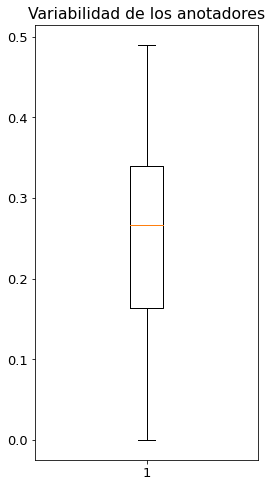

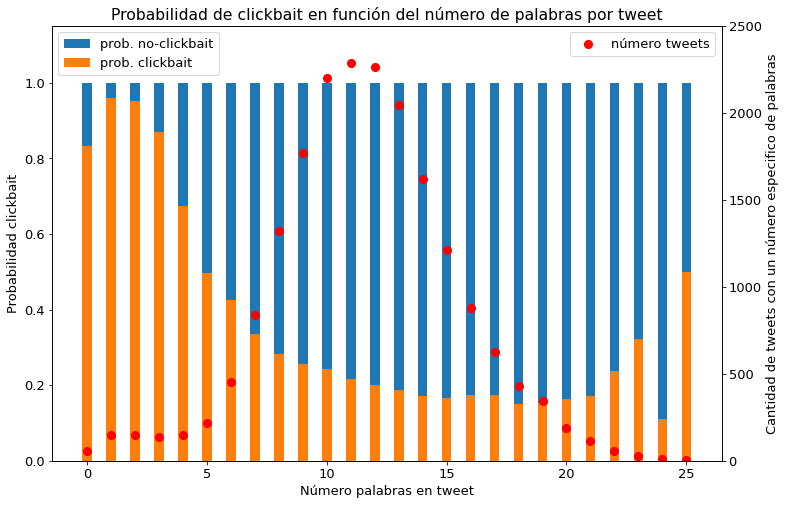

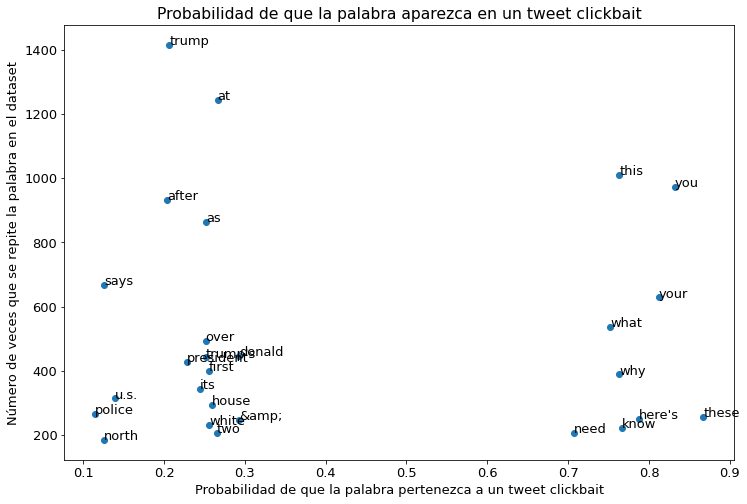

In [20]:
def pre_descriptive_analysis(dir, p):
  data = data_processing.process_file(dir, p['inputs'])

  descriptive_analysis.overall_info(data)
  descriptive_analysis.study_std(data)
  descriptive_analysis.probability_clickbait_per_tweet_count_words(data)
  descriptive_analysis.given_word_check_probability_clickbait(data)

pre_descriptive_analysis(default_config['train_dir'], p)

In [13]:
config = default_config
config['do_training'] = False
config['do_evaluation_test'] = True

p = config 

data_train = data_processing.process_file(p['train_dir'], p['inputs'])

if p['do_descriptive_analysis']:
  descriptive_analysis.overall_info(data_train)
  descriptive_analysis.study_std(data_train)
  descriptive_analysis.probability_clickbait_per_words_clickbait(data_train)
  descriptive_analysis.given_word_check_probability_clickbait(data_train)

else:
  tokenizer = AutoTokenizer.from_pretrained(p['checkpoint'])
  data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  if p['do_training']:
    data_dic_train = data_processing.to_Dataset(data_train,
                                                clip=p['clip'],
                                                split=True, 
                                                train_val_split = p['train_val_split'])

    tokenized_dataset = data_processing.tokenize_dataset(data_dic_train, 
                                                        tokenizer)
    
    # Parameter to weight cross entropy loss function according to data proportion.
    n_clickbaits_train = data_dic_train['train']['labels'].count(1)
    n_noclickbaits_train = data_dic_train['train']['labels'].count(0)
    prop_clickbait =  n_clickbaits_train / n_noclickbaits_train
    
    objective = Objective(p, tokenizer, data_collator, tokenized_dataset, prop_clickbait)
    study = optuna.create_study(study_name=p['model_name'], direction='maximize') 
    study.optimize(objective, n_trials=p['n_trials'], callbacks=[objective.callback]) 
    objective.best_model.save_pretrained(p['finetuned_model_dir'])

  if p['do_evaluation_test']:
    # model
    model = AutoModelForSequenceClassification.from_pretrained(
            'Stremie/test', num_labels=2, return_dict=True) #p['cloud_dir']
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()

    # metric
    metric = load_metric("glue", "mrpc")

    # load data
    data_test = data_processing.process_file(p['test_dir'], p['inputs'])
    data_dic_test = data_processing.to_Dataset(data_test,
                                              split=False)

    # tokenize
    tokenized_test = data_processing.tokenize_dataset(data_dic_test, 
                                                         tokenizer)

    tokenized_test = datasets.Dataset.from_dict({
        'input_ids': tokenized_test['train']['input_ids'],
        'token_type_ids': tokenized_test['train']['token_type_ids'],
        'attention_mask': tokenized_test['train']['attention_mask'],
        'labels': tokenized_test['train']['labels']}).set_format("torch")

    # create loader    
    test_loader = DataLoader(
        tokenized_test, batch_size=32, collate_fn=data_collator)

    # compute overall accuracy and F1-score
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])

    results = metric.compute()
    print(results)

  0%|          | 0/19 [00:00<?, ?ba/s]

Downloading:   0%|          | 0.00/763 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

{'accuracy': 0.8524685178355024, 'f1': 0.7285769678169832}


In [ ]:
# Para guardar modelos en la nube
!pip install huggingface_hub -q
!sudo apt-get install git-lfs -q

!huggingface-cli login

from huggingface_hub import notebook_login
notebook_login()

model = AutoModelForSequenceClassification.from_pretrained(
            p['finetuned_model_dir'], num_labels=2, return_dict=True)

model.push_to_hub(str(default_config['model_name'] + '-best'), use_temp_dir=True)
tokenizer.push_to_hub(str(default_config['model_name'] + '-best'), use_temp_dir=True)


[Volver al índice](#Index)
# <font color='orange'> Análisis descriptivo </font>
Se realiza un análisis descriptivo básico, que incluye: 

*   Variabilidad de los anotadores
*   Probabilidad de clickbait en función del número de palabras por tweet
*   Probabilidad de que la palabra pertenezca a un clickbait


In [ ]:
#descriptive_config = default_config
#descriptive_config['do_descriptive_analysis'] = True

#pipeline(p=descriptive_config)

<font color='lightgreen'> Variabilidad de los anotadores </font>

Resulta interesante observar la variación de las puntuaciones del conjunto de anotadores para cada tweet. Esto puede representarse como un diagrama de cajas de la desviación típica de las puntuaciones.

A la vista de los datos, los anotadores no tienen un consenso muy definido entre sus valoraciones, lo cual podría resultar en confusiones a la hora de entrenar la red neuronal. 

Dado que los mayores valores de desviación típica implica que la correspondiente media está relativamente centrada (uno de los dos casos de mayor desviación típica sería el conjunto de puntuaciones [1, 1, 1, 0, 0], con media = 0.6 y desviación típica ~0.49), resulta relativamente seguro eliminar aquellos datos cuya media de las puntuaciones se encuentre cercana a 0.5.

Esto además nos permite descartar tweets con conjuntos de puntuaciones no polarizados, por ejemplo [0.66, 0.66, 0.66, 0.33, 0.33]. Aunque dicho tweet se considere clickbait, el conjunto de los anotadores no tiene certeza de ello, y puede provocar errores de clasificación durante el entrenamiento.

La cantidad de datos a descartar se tomará como un hiperparámetro. Esto puede perjudicar en que hay un menor número de datos que entrenar, por lo que no resulta obvio que vaya a mejorar el modelo. Por lo tanto, la cantidad de datos a descartar se tomará como un hiperparámetro.

*Nota: Esta idea proviene de este proyecto: [Click-BERT: Clickbait Detector with Bidirectional Encoder Representations
from Transformers](https://github.com/PeterQiu0516/Click-BERT/blob/main/Final-Report/EECS498NLP_Project_Final_Report.pdf)*, donde aseguran que mejoran las predicciones.



<font color='lightgreen'> Probabilidad de clickbait en función del número de palabras por tweet </font>

A la vista de la gráfica, podemos observar que la mayoría de tweets con un número de palabras muy bajo suele ser clickbait, y dicha probabilidad tiende a reducirse generalizadamente conforme aumenta el número de palabras. 

<font color='lightgreen'> Probabilidad de que la palabra aparezca en un clickbait </font>

Estos resultados no resultan muy reveladores, pero dan pequeñas pistas de qué se puede considerar legítimo y qué puede considerarse clickbait.

Por ejemplo, entre las palabras que más aparecen en los tweets que son clickbaits aparecen apelativos al lector 'you'/'your', preguntas 'what'/'why' y adjetivos demostrativos 'this'/'these'. 

En el caso de tweets legítimos, parece que tiende a poseer palabras menos ambiguas, tales como 'u.s.'/'police'/'trump'/'president'.

Igualmente hay clasificaciones extrañas. Por ejemplo, 'says' se ha catalogado como una palabra que se usa mucho en tweets legítimos, cuando es una palabra que puede recordar a un clickbait.

# <font color='orange'> Hugging Face dataset y tokenización </font>

In [ ]:
torch.cuda.empty_cache()